This notebook is like `twofold_gwot`, but it uses the classes `SpacePair` and `GWOT`.
I want to investigate the differences between various sizes of projection alignment.

- Use the spaces from the 1850s and 1900s.
- How small to go with the coupling sizes? (100/150/20/250/...)
- Use frequency information for small couplings?
- Optimize/load a translation coupling 
    - on 4K/5K words (most frequent in each space)
    - without frequency information
- Optimize a projection coupling
    - as small as reasonable
    - with frequency information (added relative frequency)
- Investigate $T_P$:
    - matches/mismatches
    - function vs. content words
- Investigate $T$:
    - matches/mismatches
    - self-similarity 
    - differences of self-similarity between anchors and non-anchors
- Investigate $T_{shift}$ (i.e., $T$ without anchor words):
    - projected similarity
    - nearest neighbors
    - Self-similarity vs. projected similarity

In [1]:
#from otalign.src import bilind
import utils
import default
from SpacePair import SpacePair
from GWOT import GWOT

import math
import time
import os
import collections
from glob import glob
import pickle
from typing import List, Dict, Tuple

import numpy as np
from numpy.linalg import norm
from scipy.stats import spearmanr

import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import ot

In [ ]:
def matchbins(scores, magnify=1e3, threshold=0) -> (List[str], List[str]): # for histogram analyses later on
    matches, mismatches = [], []
    for (s, t), score in scores.items():
        score *= magnify
        if score > threshold:
            if s != t:
                mismatches.append(score)
            else:
                matches.append(score)
    return matches, mismatches

def neighbors(x:np.ndarray, embeddings:np.ndarray, vocab:List[str], normed:bool=True, k:int=5) -> List[str]:
    """ return the words of the vectors with the k highest cosines to an embedding x """
    if type(vocab) is dict:
        vocab = sorted(vocab, key=vocab.get)
    sims = cosines(x, embeddings, vocab, normed=normed)
    output = []
    for sim_idx in sims.argsort()[::-1][1:(1+k)]:
        if sims[sim_idx] > 0:
            output.append(vocab[sim_idx] if sim_idx <= len(vocab) else "NONE")
            
    return output

def cosines(x:np.ndarray, embeddings:np.ndarray, vocab:List[str], normed:bool=True) -> np.ndarray:
    """ calculate the cosine values between an embedding x and other embeddings. """
    if normed:
        sims = np.dot(x, embeddings.T) # similarity values of all embeddings with 'query'
    else:
        numerators = np.dot(x, embeddings.T) # .T needed because it's a 'matrix'

        d_x = math.sqrt(np.dot(x, x)) # first part of the denominator
        denominators = np.array([math.sqrt(np.dot(e,e)) for e in embeddings])
        
        sims = numerators/(1e-5 + d_x*denominators)  # 1e-5 avoids ZeroDivisionErrors

    return sims

In [4]:
""" parameter input """
take_time = utils.Timer()

config_filepath = "config/few_anchors_SpacePair.cfg"

# if init_all was False, we would need to call set the `gwot` attributes of spacepair manually
# (with the GWOT constructor, passing a ConfigReader object).
spacepair = SpacePair.from_config(config_filepath, init_all=True)
take_time("setting up SpacePair")

lines: 4630it [00:00, 46299.71it/s]

loading space from data/vectors1929-init-tc1-t3/rsc-all-corr-183.txt ...


lines: 183156it [00:03, 54069.07it/s]
lines: 5054it [00:00, 50533.90it/s]

loading space from data/vectors1929-init-tc1-t3/rsc-all-corr-186.txt ...


lines: 183156it [00:03, 52894.90it/s]
reading frequencies: 462166it [00:00, 484476.28it/s]


Initializing Gromov-Wasserstein Aligners ...
Initializing coupling instance.
loading pre-trained coupling from: 
   outputs/1830_1860_10000_uniform/ ...
   estimating p and q based on the coupling ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation
Initializing coupling instance.
selecting 1000 words for alignment by frequency ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation

Trying to get T and P (translation pairs and projection matrix) ...
Warning in sort_out_mapping(): missing a required attribute. Returning empty matrix.


11.355855226516724

In [5]:
print(spacepair.cfg)

root_abspath	
subproject_dir	new_few_anchors/
source_space_relpath	data/vectors1929-init-tc1-t3/rsc-all-corr-183.txt
target_space_relpath	data/vectors1929-init-tc1-t3/rsc-all-corr-186.txt
source_year	1830
target_year	1860
freq_files	data/words_of_interest/words_of_interest/decFreq1929.tsv
freq_file_separator		
freq_file_has_header	True
log_flat_base	e
translation_coupling_pretrained_reldir	outputs/1830_1860_10000_uniform/
translation_coupling_save_reldir	outputs/spacepair_demo/trans_coupling/
translation_coupling_config_relpath	outputs/1830_1860_10000_uniform/config.cfg
translation_coupling_size	10000
projection_coupling_save_reldir	outputs/spacepair_demo/proj_coupling/
projection_coupling_config_relpath	config/proj_gwot_1000it.cfg
projection_coupling_size	1000
data_abspath	data/new_few_anchors/
visuals_abspath	visuals/new_few_anchors/
outputs_abspath	outputs/new_few_anchors/
src_space_abspath	data/vectors1929-init-tc1-t3/rsc-all-corr-183.txt
trg_space_abspath	data/vectors1929-init-tc1

In [6]:
print(str(spacepair.gwot1.compile_config()))

pretrained_loc	outputs/1830_1860_10000_uniform/
out_absdir	outputs/spacepair_demo/trans_coupling/
score_type	coupling
adjust	None
metric	cosine
normalize_vecs	both
normalize_dists	both
distribs	uniform
share_vocs	False
size	10000
opt_loss_fun	square_loss
opt_entropic	True
opt_entreg	0.0005
opt_tol	1e-09
opt_round_g	False
fit_maxiter	300
fit_print_every	10
fit_verbose	True
fit_plot_every	100000
fit_save_plots	None


In [7]:
print(str(spacepair.gwot2.compile_config()))

pretrained_loc	None
out_absdir	outputs/spacepair_demo/proj_coupling/
score_type	coupling
adjust	None
metric	cosine
normalize_vecs	both
normalize_dists	both
distribs	custom
share_vocs	False
size	1000
opt_loss_fun	square_loss
opt_entropic	True
opt_entreg	0.0005
opt_tol	1e-09
opt_round_g	False
fit_maxiter	1000
fit_plot_every	20
fit_print_every	1
fit_verbose	True
fit_save_plots	None


As `gwot2` has no `size` parameter set, we have to do that manually now. Note that in order to change `GWOT` object in hindsight, the safest approach is to (1) get its config, (2) change that config, (3) make a new GWOT object and overwrite the old one.

In [8]:
spacepair.gwot2.out_absdir = "outputs/few_anchors/"
if not os.path.exists(spacepair.gwot2.out_absdir):
    os.makedirs(spacepair.gwot2.out_absdir)

In [9]:
new_gwot2cfg = spacepair.gwot2.compile_config()
new_gwot2cfg.set("size", 100)
new_gwot2cfg.set("distribs", "custom")
new_gwot2cfg.set("entreg", 5e-4)
spacepair.gwot2 = spacepair.new_aligner(new_gwot2cfg)

Initializing coupling instance.
selecting 100 words for alignment by frequency ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation
Warning in sort_out_scored_mutual_nn(): missing a required attribute. Returning empty dict.
Warning in sort_out_mapping(): missing a required attribute. Returning empty matrix.


In [10]:
spacepair.gwot2.fit(spacepair.X, spacepair.Y, spacepair.voc_x, spacepair.voc_y,
                    maxiter=1000, verbose=True, print_every=50, plot_every=10000)
spacepair.P = spacepair.gwot2.mapping

Fitting bilingual mapping with Gromov Wasserstein
Normalizing embeddings with: both
Solving optimization problem...
Computing intra-domain distance matrices...
Stats Distance Matrix C1. mean:     1.00, median:     1.03,             min:     0.00, max:    1.43
Stats Distance Matrix C2. mean:     1.00, median:     1.03,             min:     0.00, max:    1.39
------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
    0   3.35e-02  -1.01e+01   4.42e-03   0.2187   0.2195
   50   3.95e-03  -5.69e+00   3.68e-05   0.0069   0.0076
  100   3.95e-03  -5.69e+00   1.37e-05   0.0038   0.0045
  150   3.95e-03  -5.69e+00   5.32e-05   0.0040   0.0047
------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
  200   3.95e-03  -5.69e+00   1.13e-05   0.0018   

matches: 81
mismatches: 19
voc overlap: 93


/home/simon/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'x 1e-3')

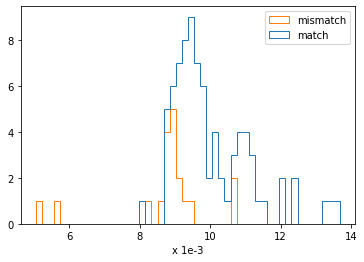

In [11]:
scored_pairs = spacepair.gwot2.scored_mutual_nn(spacepair.gwot2.scores,
                                               src_words=spacepair.gwot2.src_words,
                                               trg_words=spacepair.gwot2.trg_words)
matches, mismatches = utils.matchbins(scored_pairs)
print("matches:",len(matches))
print("mismatches:",len(mismatches))
print("voc overlap:",len(set(spacepair.gwot2.src_words).intersection(set(spacepair.gwot2.trg_words))))
plt.hist([matches, mismatches],
                 label=['match', 'mismatch'],
                 cumulative=False, histtype="step",
                 bins=50)
plt.legend()
plt.xlabel('x 1e-3')

### 1. Small couplings: How small can we go?
With couplings of this tiny size, the choices of `distribs` and `opt_entreg` have a big impact. The following shows the effect of frequency information on the coupling quality for small couplings (running for 300 iterations with `opt_entreg=5e-4`, as usual)

In [17]:
sizes = [100, 150, 200, 250, 300, 350, 400, 450, 500]
dists = ["uniform", "custom"]

unif_found = []
cust_found = []

unif_matching = []
cust_matching = []

for dist in dists:
    for size in sizes:
        new_gwot2cfg = spacepair.gwot2.compile_config()
        new_gwot2cfg.set("size", size)
        new_gwot2cfg.set("opt_entreg", 5e-4) # smaller values = stricter couplings
        new_gwot2cfg.set("distribs", dist)
        spacepair.gwot2 = spacepair.new_aligner(new_gwot2cfg)
        
        print(f"\n\nNEW RUN:\tsize: {size}\tdist: {dist}\n")
        
        spacepair.gwot2.fit(spacepair.X, spacepair.Y, 
                            spacepair.voc_x, spacepair.voc_y,
                            maxiter=300, 
                            print_every=100, 
                            plot_every=10000)
        proj_pairs = spacepair.gwot2.scored_mutual_nn(spacepair.gwot2.scores, 
                                                      spacepair.gwot2.src_words, 
                                                      spacepair.gwot2.trg_words)
        matches, mismatches = utils.matchbins(proj_pairs)
        
        overlap = len(set(spacepair.gwot2.src_words).intersection(set(spacepair.gwot2.trg_words)))
        
        found = len(proj_pairs)/size
        matching = len(matches)/overlap
        
        if dist == "uniform":
            unif_found.append(found)
            unif_matching.append(matching)
        elif dist == "custom":
            cust_found.append(found)
            cust_matching.append(matching)
        
        print(len(proj_pairs),"\tpairs")
        print(len(matches),"\tmatches")
        print(len(mismatches),"\tmismatches")
        print(str(round(100*matching,2))+"%\tmatching")
        print("\n\n\n")

Initializing coupling instance.
selecting 100 words for alignment by frequency ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation
Warning in sort_out_scored_mutual_nn(): missing a required attribute. Returning empty dict.
Warning in sort_out_mapping(): missing a required attribute. Returning empty matrix.


NEW RUN:	size: 100	dist: uniform

Fitting bilingual mapping with Gromov Wasserstein
Normalizing embeddings with: both
Solving optimization problem...
Computing intra-domain distance matrices...
Stats Distance Matrix C1. mean:     1.00, median:     1.03,             min:     0.00, max:    1.43
Stats Distance Matrix C2. mean:     1.00, median:     1.03,             min:     0.00, max:    1.39
------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
    0   3.31e-02  -1.02e+01   3.01e-03   0.4826   0.4836
  100   3.97e-

------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
    0   1.76e-02  -1.27e+01   4.21e-04   0.3846   0.3963
  100   4.51e-03  -7.02e+00   1.60e-05   0.0130   0.0283
------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
  200   4.51e-03  -7.01e+00   7.79e-08   0.0141   0.0456
  300   4.51e-03  -7.01e+00   4.69e-08   0.0189   0.0351
Computing translation scores...
coupling None
Finding orthogonal mapping with 349 anchor points
349 	pairs
263 	matches
86 	mismatches
90.38%	matching




Initializing coupling instance.
selecting 400 words for alignment by frequency ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation
Warning in sort_out_scored_mutual_nn(): missing a required attribute. Returning 

Normalizing embeddings with: both
Solving optimization problem...
Computing intra-domain distance matrices...
Stats Distance Matrix C1. mean:     1.00, median:     1.02,             min:     0.00, max:    1.40
Stats Distance Matrix C2. mean:     1.00, median:     1.02,             min:     0.00, max:    1.38
------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
    0   2.29e-02  -1.15e+01   2.13e-03   0.3578   0.3610
  100   4.69e-03  -6.45e+00   3.05e-05   0.0051   0.0102
------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
  200   4.69e-03  -6.45e+00   3.76e-05   0.0068   0.0122
  300   4.69e-03  -6.45e+00   4.92e-05   0.0053   0.0096
Computing translation scores...
coupling None
Finding orthogonal mapping with 199 anchor points
199 

  300   4.62e-03  -7.42e+00   1.04e-05   0.0210   0.0462
Computing translation scores...
coupling None
Finding orthogonal mapping with 442 anchor points
442 	pairs
340 	matches
102 	mismatches
92.64%	matching




Initializing coupling instance.
selecting 500 words for alignment by frequency ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation
Warning in sort_out_scored_mutual_nn(): missing a required attribute. Returning empty dict.
Warning in sort_out_mapping(): missing a required attribute. Returning empty matrix.


NEW RUN:	size: 500	dist: custom

Fitting bilingual mapping with Gromov Wasserstein
Normalizing embeddings with: both
Solving optimization problem...
Computing intra-domain distance matrices...
Stats Distance Matrix C1. mean:     1.00, median:     1.01,             min:     0.00, max:    1.38
Stats Distance Matrix C2. mean:     1.00, median:     1.01,             min:     0.00, max:    1.36
----------------------------------------

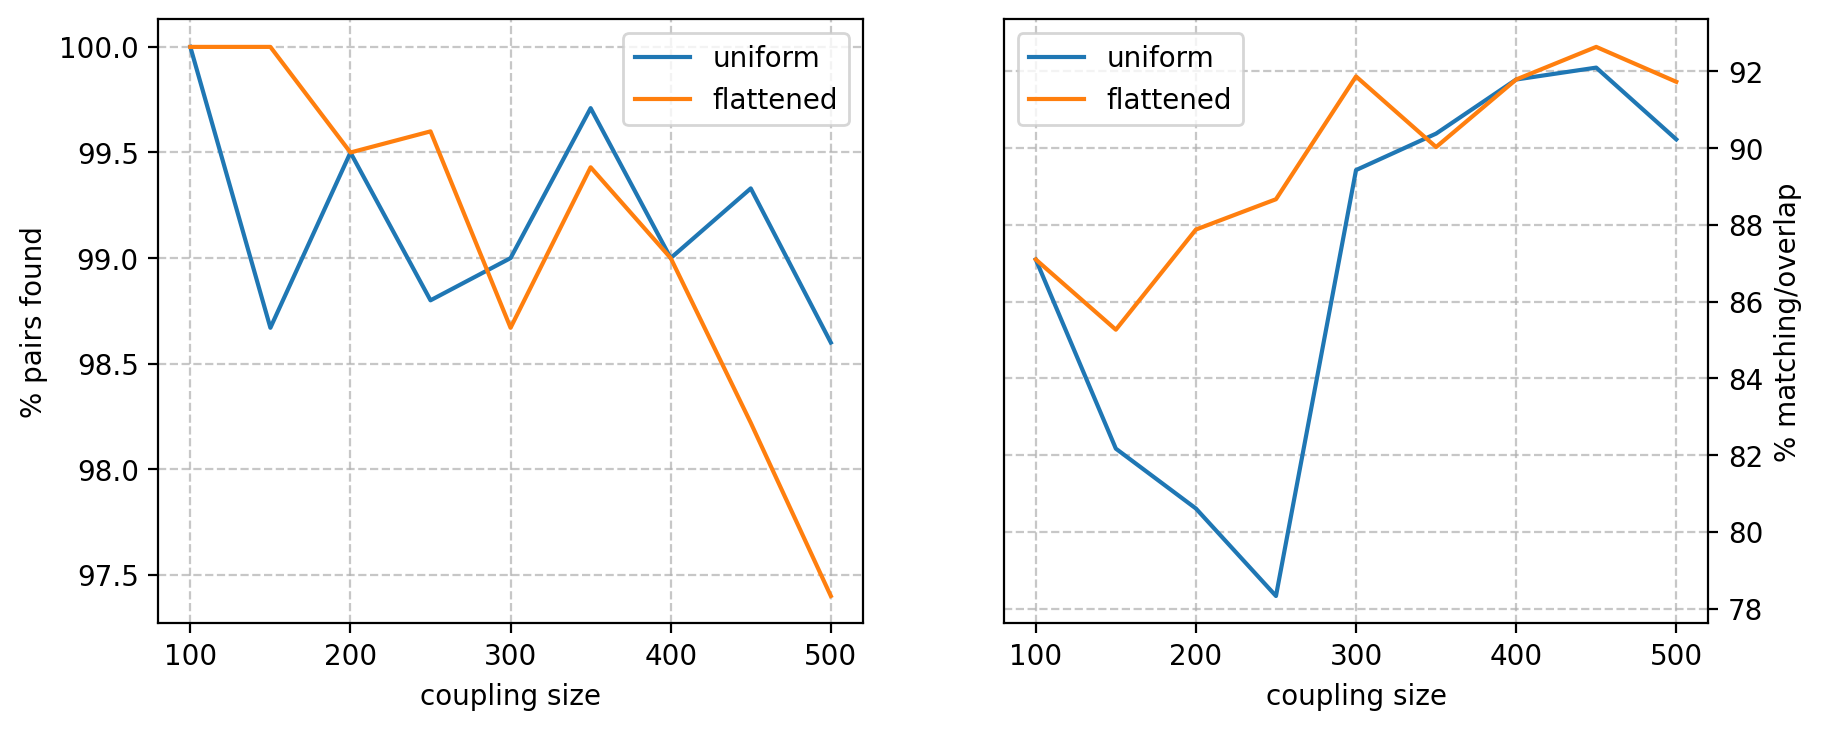

In [22]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,4), dpi=200)
#fig.suptitle()

ax1.plot(sizes, [round(v*100,2) for v in unif_found], label="uniform")
ax1.plot(sizes, [round(v*100, 2) for v in cust_found], label="flattened")
ax1.grid(linestyle="--", alpha=0.7)
ax1.legend()
ax1.set_xlabel("coupling size")
ax1.set_ylabel("% pairs found")

ax2.plot(sizes, [round(v*100,2) for v in unif_matching], label="uniform")
ax2.plot(sizes, [round(v*100,2) for v in cust_matching], label="flattened")
ax2.grid(linestyle="--", alpha=0.7)
ax2.legend()
ax2.set_xlabel("coupling size")
ax2.yaxis.tick_right()
ax2.set_ylabel("% matching/overlap")
ax2.yaxis.set_label_position("right")

#plt.savefig("visuals/few_anchors_small_1830_1860_performance.png")

The right figure shows that a custom distribution works much better for couplings with less than 300 words.
Nonetheless, the couplings with fewer than 200 words have fewer matches (relative to vocabulary overlap) than the larger ones.
Only looking at the number of pairs found (left figure), the uniform variant appears to be more stable, but the advantage over the flattened variant is not clear. Both range at 97% or above.

**Conclusion:** Couplings with less than 300 words yield more good (here: matching) translation pairs if you can provide frequency information.

### 2. Getting a projection from 100 words
Having this settled, let's make a `SpacePair` with a 10K coupling (no frequency information) for $T$ and a 300 coupling (with frequency information) from which we'll take the vectors of the 100 highest-scoring translation pairs for $P$. 

With these, I want to do the analysis from `twofold_gwot` and get concrete exampltes for shift. It's especially important to see how much $P$ shifts the vectors from $X$ in comparison to the projection matrix that we had obtained from a 1K coupling in `twofold_gwot`.

In [23]:
new_gwot2cfg = spacepair.gwot2.compile_config()
new_gwot2cfg.set("size", 300)
new_gwot2cfg.set("distribs", 'custom')
new_gwot2cfg.set("fit_maxiter", 2000)
spacepair.gwot2 = spacepair.new_aligner(new_gwot2cfg)

Initializing coupling instance.
selecting 300 words for alignment by frequency ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation
Warning in sort_out_scored_mutual_nn(): missing a required attribute. Returning empty dict.
Warning in sort_out_mapping(): missing a required attribute. Returning empty matrix.


In [24]:
spacepair.gwot2.fit(spacepair.X, spacepair.Y, spacepair.voc_x, spacepair.voc_y)


Fitting bilingual mapping with Gromov Wasserstein
Normalizing embeddings with: both
Solving optimization problem...
Computing intra-domain distance matrices...
Stats Distance Matrix C1. mean:     1.00, median:     1.02,             min:     0.00, max:    1.39
Stats Distance Matrix C2. mean:     1.00, median:     1.02,             min:     0.00, max:    1.37
------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
    0   1.88e-02  -1.23e+01   1.30e-03   0.5325   0.5399
    1   1.59e-02  -1.16e+01   3.98e-03   0.0106   0.0180
    2   1.39e-02  -1.08e+01   6.95e-03   0.0364   0.0441
    3   1.04e-02  -9.56e+00   1.57e-02   0.0606   0.0687
    4   6.35e-03  -7.99e+00   3.06e-02   0.1464   0.1566
    5   4.85e-03  -7.23e+00   2.01e-02   0.1929   0.2032
    6   4.54e-03  -7.05e+00   1.04e-02   0.3218   0.3322
    7   4.48e-03  -7.01e+00   4.85e-03   0.1611   0.1728
   

  136   4.34e-03  -6.91e+00   4.64e-05   0.0229   0.0332
  137   4.34e-03  -6.91e+00   4.35e-05   0.0255   0.0370
  138   4.34e-03  -6.91e+00   4.14e-05   0.0148   0.0249
  139   4.34e-03  -6.91e+00   3.84e-05   0.0140   0.0260
  140   4.34e-03  -6.91e+00   3.45e-05   0.3651   0.3751
  141   4.34e-03  -6.91e+00   3.44e-05   0.0131   0.0229
  142   4.34e-03  -6.91e+00   3.43e-05   0.0123   0.0223
  143   4.34e-03  -6.91e+00   3.42e-05   0.0340   0.0443
  144   4.34e-03  -6.91e+00   3.55e-05   0.0152   0.0256
  145   4.34e-03  -6.91e+00   4.37e-05   0.0106   0.0208
  146   4.34e-03  -6.91e+00   4.66e-05   0.0243   0.0335
  147   4.34e-03  -6.91e+00   5.80e-05   0.0121   0.0213
  148   4.34e-03  -6.91e+00   5.67e-05   0.0184   0.0277
  149   4.34e-03  -6.91e+00   5.12e-05   0.0660   0.0761
  150   4.34e-03  -6.91e+00   4.41e-05   0.0165   0.0277
  151   4.34e-03  -6.91e+00   4.34e-05   0.0139   0.0237
  152   4.34e-03  -6.91e+00   4.63e-05   0.0138   0.0236
  153   4.34e-03  -6.91e+00   5

  280   4.34e-03  -6.91e+00   5.18e-05   0.3684   0.3779
  281   4.34e-03  -6.91e+00   4.27e-05   0.0194   0.0312
  282   4.34e-03  -6.91e+00   4.18e-05   0.0184   0.0277
  283   4.34e-03  -6.91e+00   5.04e-05   0.0145   0.0240
  284   4.34e-03  -6.91e+00   5.68e-05   0.0228   0.0324
  285   4.34e-03  -6.91e+00   6.17e-05   0.0224   0.0320
  286   4.34e-03  -6.91e+00   6.14e-05   0.0149   0.0242
  287   4.34e-03  -6.91e+00   5.62e-05   0.0131   0.0227
  288   4.34e-03  -6.91e+00   4.98e-05   0.0147   0.0289
  289   4.34e-03  -6.91e+00   4.51e-05   0.0166   0.0278
  290   4.34e-03  -6.91e+00   4.22e-05   0.0148   0.0248
  291   4.34e-03  -6.91e+00   3.91e-05   0.0140   0.0239
  292   4.34e-03  -6.91e+00   3.53e-05   0.0141   0.0240
  293   4.34e-03  -6.91e+00   3.54e-05   0.0135   0.0237
  294   4.34e-03  -6.91e+00   3.54e-05   0.0182   0.0301
  295   4.34e-03  -6.91e+00   3.51e-05   0.0165   0.0283
  296   4.34e-03  -6.91e+00   3.57e-05   0.0140   0.0297
  297   4.34e-03  -6.91e+00   3

/home/simon/Desktop/thesis/GWOT/otalign/src/gw_optim.py:257: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))


------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
  400   4.34e-03  -6.91e+00   3.73e-05   0.3803   0.3895
  401   4.34e-03  -6.91e+00   3.87e-05   0.0115   0.0206
  402   4.34e-03  -6.91e+00   3.40e-05   0.0157   0.0254
  403   4.34e-03  -6.91e+00   3.33e-05   0.0133   0.0227
  404   4.34e-03  -6.91e+00   3.43e-05   0.0132   0.0233
  405   4.34e-03  -6.91e+00   4.14e-05   0.0134   0.0227
  406   4.34e-03  -6.91e+00   4.68e-05   0.0137   0.0243
  407   4.34e-03  -6.91e+00   5.08e-05   0.0160   0.0262
  408   4.34e-03  -6.91e+00   5.55e-05   0.0141   0.0320
  409   4.34e-03  -6.91e+00   5.17e-05   0.0398   0.0493
  410   4.34e-03  -6.91e+00   4.47e-05   0.0196   0.0295
  411   4.34e-03  -6.91e+00   4.30e-05   0.0136   0.0235
  412   4.34e-03  -6.91e+00   4.34e-05   0.0135   0.0234
  413   4.34e-03  -6.91e+00   4.86e-05   0.0136   0.0270
  414   4.34e-03  -6.

  548   4.34e-03  -6.91e+00   4.78e-05   0.0157   0.0267
  549   4.34e-03  -6.91e+00   4.48e-05   0.0161   0.0343
  550   4.34e-03  -6.91e+00   4.34e-05   0.0147   0.0244
  551   4.34e-03  -6.91e+00   4.16e-05   0.0163   0.0285
  552   4.34e-03  -6.91e+00   3.84e-05   0.0250   0.0371
  553   4.34e-03  -6.91e+00   3.42e-05   0.0263   0.0434
  554   4.34e-03  -6.91e+00   3.39e-05   0.0155   0.0326
  555   4.34e-03  -6.91e+00   3.40e-05   0.0345   0.0479
  556   4.34e-03  -6.91e+00   3.49e-05   0.0133   0.0237
  557   4.34e-03  -6.91e+00   4.20e-05   0.0100   0.0199
  558   4.34e-03  -6.91e+00   4.71e-05   0.0118   0.0214
  559   4.34e-03  -6.91e+00   5.05e-05   0.0135   0.0231
  560   4.34e-03  -6.91e+00   5.52e-05   0.3403   0.3491
  561   4.34e-03  -6.91e+00   5.17e-05   0.0137   0.0226
  562   4.34e-03  -6.91e+00   4.53e-05   0.0140   0.0227
  563   4.34e-03  -6.91e+00   4.41e-05   0.0124   0.0211
  564   4.34e-03  -6.91e+00   4.49e-05   0.0121   0.0208
  565   4.34e-03  -6.91e+00   5

  694   4.34e-03  -6.91e+00   4.56e-05   0.0402   0.0503
  695   4.34e-03  -6.91e+00   5.21e-05   0.0137   0.0239
  696   4.34e-03  -6.91e+00   6.46e-05   0.0168   0.0270
  697   4.34e-03  -6.91e+00   6.41e-05   0.0200   0.0299
  698   4.34e-03  -6.91e+00   6.25e-05   0.0297   0.0396
  699   4.34e-03  -6.91e+00   5.58e-05   0.0160   0.0259
  700   4.34e-03  -6.91e+00   4.41e-05   0.3841   0.3945
  701   4.34e-03  -6.91e+00   4.09e-05   0.0303   0.0429
  702   4.34e-03  -6.91e+00   4.03e-05   0.0261   0.0369
  703   4.34e-03  -6.91e+00   3.91e-05   0.0279   0.0447
  704   4.34e-03  -6.91e+00   4.27e-05   0.0193   0.0310
  705   4.34e-03  -6.91e+00   3.80e-05   0.0271   0.0378
  706   4.34e-03  -6.91e+00   3.26e-05   0.0433   0.0546
  707   4.34e-03  -6.91e+00   3.61e-05   0.0217   0.0326
  708   4.34e-03  -6.91e+00   3.65e-05   0.0246   0.0355
  709   4.34e-03  -6.91e+00   3.88e-05   0.0248   0.0357
  710   4.34e-03  -6.91e+00   4.50e-05   0.0111   0.0201
  711   4.34e-03  -6.91e+00   5

  838   4.34e-03  -6.91e+00   3.43e-05   0.0120   0.0269
  839   4.34e-03  -6.91e+00   3.68e-05   0.0277   0.0375
  840   4.34e-03  -6.91e+00   4.70e-05   0.3455   0.3543
  841   4.34e-03  -6.91e+00   5.08e-05   0.0142   0.0230
  842   4.34e-03  -6.91e+00   5.60e-05   0.0121   0.0210
  843   4.34e-03  -6.91e+00   5.31e-05   0.0143   0.0235
  844   4.34e-03  -6.91e+00   4.67e-05   0.0146   0.0238
  845   4.34e-03  -6.91e+00   4.47e-05   0.0129   0.0222
  846   4.34e-03  -6.91e+00   4.34e-05   0.0129   0.0221
  847   4.34e-03  -6.91e+00   4.61e-05   0.0127   0.0219
  848   4.34e-03  -6.91e+00   5.63e-05   0.0121   0.0213
  849   4.34e-03  -6.91e+00   6.07e-05   0.0165   0.0288
  850   4.34e-03  -6.91e+00   6.04e-05   0.0209   0.0310
  851   4.34e-03  -6.91e+00   5.56e-05   0.0126   0.0218
  852   4.34e-03  -6.91e+00   4.96e-05   0.0129   0.0226
  853   4.34e-03  -6.91e+00   4.57e-05   0.0133   0.0231
  854   4.34e-03  -6.91e+00   4.34e-05   0.0148   0.0246
  855   4.34e-03  -6.91e+00   4

  990   4.34e-03  -6.91e+00   3.63e-05   0.0324   0.0416
  991   4.34e-03  -6.91e+00   3.81e-05   0.0111   0.0203
  992   4.34e-03  -6.91e+00   4.35e-05   0.0110   0.0201
  993   4.34e-03  -6.91e+00   5.34e-05   0.0112   0.0230
  994   4.34e-03  -6.91e+00   5.94e-05   0.0169   0.0295
  995   4.34e-03  -6.91e+00   5.61e-05   0.0191   0.0308
  996   4.34e-03  -6.91e+00   4.88e-05   0.0189   0.0294
  997   4.34e-03  -6.91e+00   4.11e-05   0.0218   0.0319
  998   4.34e-03  -6.91e+00   4.20e-05   0.0234   0.0332
  999   4.34e-03  -6.91e+00   5.14e-05   0.0259   0.0356
------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
 1000   4.34e-03  -6.91e+00   5.76e-05   0.3427   0.3524
 1001   4.34e-03  -6.91e+00   6.17e-05   0.0124   0.0222
 1002   4.34e-03  -6.91e+00   6.05e-05   0.0218   0.0321
 1003   4.34e-03  -6.91e+00   5.44e-05   0.0215   0.0319
 1004   4.34e-03  -6.

 1137   4.34e-03  -6.91e+00   4.13e-05   0.0235   0.0417
 1138   4.34e-03  -6.91e+00   3.76e-05   0.0401   0.0493
 1139   4.34e-03  -6.91e+00   3.33e-05   0.0194   0.0329
 1140   4.34e-03  -6.91e+00   3.28e-05   0.3657   0.3745
 1141   4.34e-03  -6.91e+00   3.30e-05   0.0106   0.0192
 1142   4.34e-03  -6.91e+00   3.80e-05   0.0134   0.0222
 1143   4.34e-03  -6.91e+00   3.99e-05   0.0107   0.0194
 1144   4.34e-03  -6.91e+00   4.50e-05   0.0107   0.0199
 1145   4.34e-03  -6.91e+00   4.92e-05   0.0126   0.0217
 1146   4.34e-03  -6.91e+00   5.48e-05   0.0127   0.0219
 1147   4.34e-03  -6.91e+00   5.87e-05   0.0126   0.0590
 1148   4.34e-03  -6.91e+00   4.54e-05   0.0231   0.0450
 1149   4.34e-03  -6.91e+00   4.23e-05   0.0145   0.0237
 1150   4.34e-03  -6.91e+00   4.32e-05   0.0126   0.0216
 1151   4.34e-03  -6.91e+00   5.21e-05   0.0111   0.0202
 1152   4.34e-03  -6.91e+00   5.77e-05   0.0127   0.0218
 1153   4.34e-03  -6.91e+00   6.16e-05   0.0150   0.0247
 1154   4.34e-03  -6.91e+00   6

 1279   4.34e-03  -6.91e+00   4.33e-05   0.0268   0.0365
 1280   4.34e-03  -6.91e+00   4.22e-05   0.3415   0.3503
 1281   4.34e-03  -6.91e+00   4.55e-05   0.0123   0.0210
 1282   4.34e-03  -6.91e+00   5.62e-05   0.0113   0.0201
 1283   4.34e-03  -6.91e+00   6.13e-05   0.0121   0.0209
 1284   4.34e-03  -6.91e+00   6.17e-05   0.0127   0.0219
 1285   4.34e-03  -6.91e+00   5.68e-05   0.0128   0.0223
 1286   4.34e-03  -6.91e+00   4.97e-05   0.0186   0.0278
 1287   4.34e-03  -6.91e+00   4.47e-05   0.0129   0.0220
 1288   4.34e-03  -6.91e+00   4.24e-05   0.0126   0.0217
 1289   4.34e-03  -6.91e+00   4.07e-05   0.0169   0.0263
 1290   4.34e-03  -6.91e+00   3.81e-05   0.0256   0.0357
 1291   4.34e-03  -6.91e+00   3.97e-05   0.0112   0.0203
 1292   4.34e-03  -6.91e+00   3.50e-05   0.0127   0.0219
 1293   4.34e-03  -6.91e+00   3.41e-05   0.0116   0.0213
 1294   4.34e-03  -6.91e+00   3.48e-05   0.0118   0.0249
 1295   4.34e-03  -6.91e+00   4.14e-05   0.0101   0.0198
 1296   4.34e-03  -6.91e+00   4

 1420   4.34e-03  -6.91e+00   4.02e-05   0.3768   0.3962
 1421   4.34e-03  -6.91e+00   3.56e-05   0.0279   0.0377
 1422   4.34e-03  -6.91e+00   3.52e-05   0.0253   0.0456
 1423   4.34e-03  -6.91e+00   3.51e-05   0.0124   0.0224
 1424   4.34e-03  -6.91e+00   3.53e-05   0.0123   0.0217
 1425   4.34e-03  -6.91e+00   3.76e-05   0.0144   0.0240
 1426   4.34e-03  -6.91e+00   4.37e-05   0.0137   0.0249
 1427   4.34e-03  -6.91e+00   5.42e-05   0.0180   0.0321
 1428   4.34e-03  -6.91e+00   6.04e-05   0.0250   0.0352
 1429   4.34e-03  -6.91e+00   5.66e-05   0.0158   0.0255
 1430   4.34e-03  -6.91e+00   4.87e-05   0.0153   0.0250
 1431   4.34e-03  -6.91e+00   4.07e-05   0.0152   0.0248
 1432   4.34e-03  -6.91e+00   4.19e-05   0.0134   0.0230
 1433   4.34e-03  -6.91e+00   5.19e-05   0.0482   0.0580
 1434   4.34e-03  -6.91e+00   5.87e-05   0.0396   0.0598
 1435   4.34e-03  -6.91e+00   6.27e-05   0.0187   0.0291
 1436   4.34e-03  -6.91e+00   6.09e-05   0.0136   0.0234
 1437   4.34e-03  -6.91e+00   5

 1566   4.34e-03  -6.91e+00   5.91e-05   0.0263   0.0506
 1567   4.34e-03  -6.91e+00   5.44e-05   0.0353   0.0513
 1568   4.34e-03  -6.91e+00   4.95e-05   0.0245   0.0353
 1569   4.34e-03  -6.91e+00   4.60e-05   0.0301   0.0421
 1570   4.34e-03  -6.91e+00   4.36e-05   0.0288   0.0398
 1571   4.34e-03  -6.91e+00   4.06e-05   0.0597   0.0690
 1572   4.34e-03  -6.91e+00   3.65e-05   0.0131   0.0221
 1573   4.34e-03  -6.91e+00   3.67e-05   0.0167   0.0259
 1574   4.34e-03  -6.91e+00   3.23e-05   0.0132   0.0224
 1575   4.34e-03  -6.91e+00   3.57e-05   0.0137   0.0258
 1576   4.34e-03  -6.91e+00   3.66e-05   0.0198   0.0329
 1577   4.34e-03  -6.91e+00   4.02e-05   0.0214   0.0400
 1578   4.34e-03  -6.91e+00   4.80e-05   0.0296   0.0469
 1579   4.34e-03  -6.91e+00   5.99e-05   0.0266   0.0425
 1580   4.34e-03  -6.91e+00   5.83e-05   0.3922   0.3998
 1581   4.34e-03  -6.91e+00   5.24e-05   0.0125   0.0204
 1582   4.34e-03  -6.91e+00   4.45e-05   0.0156   0.0243
 1583   4.34e-03  -6.91e+00   4

 1710   4.34e-03  -6.91e+00   5.96e-05   0.0146   0.0249
 1711   4.34e-03  -6.91e+00   5.15e-05   0.0321   0.0416
 1712   4.34e-03  -6.91e+00   4.18e-05   0.0150   0.0246
 1713   4.34e-03  -6.91e+00   3.95e-05   0.0135   0.0230
 1714   4.34e-03  -6.91e+00   4.62e-05   0.0114   0.0209
 1715   4.34e-03  -6.91e+00   5.20e-05   0.0130   0.0226
 1716   4.34e-03  -6.91e+00   6.24e-05   0.0116   0.0211
 1717   4.34e-03  -6.91e+00   6.36e-05   0.0135   0.0230
 1718   4.34e-03  -6.91e+00   5.91e-05   0.0132   0.0238
 1719   4.34e-03  -6.91e+00   4.86e-05   0.0348   0.0445
 1720   4.34e-03  -6.91e+00   4.56e-05   0.3388   0.3475
 1721   4.34e-03  -6.91e+00   4.49e-05   0.0119   0.0204
 1722   4.34e-03  -6.91e+00   4.36e-05   0.0474   0.0566
 1723   4.34e-03  -6.91e+00   4.07e-05   0.0141   0.0232
 1724   4.34e-03  -6.91e+00   3.63e-05   0.0125   0.0222
 1725   4.34e-03  -6.91e+00   3.61e-05   0.0109   0.0199
 1726   4.34e-03  -6.91e+00   3.60e-05   0.0107   0.0197
 1727   4.34e-03  -6.91e+00   3

 1854   4.34e-03  -6.91e+00   3.85e-05   0.0479   0.0605
 1855   4.34e-03  -6.91e+00   3.41e-05   0.0178   0.0274
 1856   4.34e-03  -6.91e+00   3.34e-05   0.0259   0.0373
 1857   4.34e-03  -6.91e+00   3.81e-05   0.0131   0.0390
 1858   4.34e-03  -6.91e+00   3.99e-05   0.0158   0.0281
 1859   4.34e-03  -6.91e+00   4.47e-05   0.0233   0.0336
 1860   4.34e-03  -6.91e+00   5.38e-05   0.3836   0.3928
 1861   4.34e-03  -6.91e+00   5.38e-05   0.0165   0.0257
 1862   4.34e-03  -6.91e+00   5.77e-05   0.0164   0.0272
 1863   4.34e-03  -6.91e+00   5.14e-05   0.0255   0.0366
 1864   4.34e-03  -6.91e+00   4.30e-05   0.0201   0.0297
 1865   4.34e-03  -6.91e+00   4.29e-05   0.0185   0.0295
 1866   4.34e-03  -6.91e+00   4.86e-05   0.0167   0.0264
 1867   4.34e-03  -6.91e+00   6.09e-05   0.0118   0.0214
 1868   4.34e-03  -6.91e+00   6.55e-05   0.0178   0.0382
 1869   4.34e-03  -6.91e+00   6.36e-05   0.0244   0.0362
 1870   4.34e-03  -6.91e+00   5.25e-05   0.0184   0.0288
 1871   4.34e-03  -6.91e+00   4

------------------------------------------------------------
    T        obj    entropy    delta_G   time_G time_total
------------------------------------------------------------
 2000   4.34e-03  -6.91e+00   5.75e-05   0.3811   0.3907
Computing translation scores...
coupling None
Finding orthogonal mapping with 296 anchor points


In [49]:
projection_size = 100

src_embs, src_voc = utils.select_subspace(spacepair.X, spacepair.voc_x, spacepair.gwot2.src_words)
trg_embs, trg_voc = utils.select_subspace(spacepair.Y, spacepair.voc_y, spacepair.gwot2.trg_words)

spacepair.P = spacepair.gwot2.get_mapping(src_embs, trg_embs, src_voc, trg_voc, max_anchors=projection_size)

Finding orthogonal mapping with 100 anchor points


#### Mismatch Analysis of $T_P$

296 	pairs
226 	matches
70 	mismatches
246 	overlap


/home/simon/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


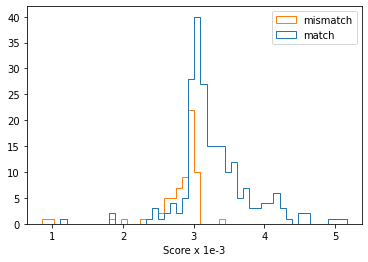

In [42]:
T_P = spacepair.gwot2.scored_mutual_nn(spacepair.gwot2.scores, 
                                       spacepair.gwot2.src_words, 
                                       spacepair.gwot2.trg_words)
matches, mismatches = utils.matchbins(T_P)
print(len(T_P), "\tpairs")
print(len(matches), "\tmatches")
print(len(mismatches), "\tmismatches")
print(len(set(spacepair.gwot2.src_words).intersection(set(spacepair.gwot2.trg_words))), "\toverlap")

hist_bins = 50
plt.hist([matches, mismatches], bins=hist_bins, label=['match','mismatch'], cumulative=False, histtype="step")
plt.xlabel('Score x 1e-3')
plt.legend()

In [43]:
for rank, (x,y) in enumerate(sorted(T_P, key=T_P.get, reverse=True)):
    score = T_P[(x,y)]    
    if x!=y: print(f"mismatch {rank:>4}   {round(score*1000, 5):6.5f}   {x:<15} {y:<15}")
    else:    print(f"         {rank:>4}   {round(score*1000, 5):6.5f}   {x:<15} {y:<15}")

            0   5.16459   the             the            
            1   5.00956   ,               ,              
            2   4.95952   of              of             
            3   4.63570   and             and            
            4   4.63238   in              in             
            5   4.55171   to              to             
            6   4.51201   a               a              
            7   4.35296   is              is             
            8   4.23924   by              by             
            9   4.22280   that            that           
           10   4.21676   which           which          
           11   4.20331   (               (              
           12   4.17740   )               )              
           13   4.17612   it              it             
           14   4.17085   as              as             
           15   4.16950   be              be             
           16   4.16689   with            with           
           17 

This looks good: most of the words used for the coupling are function words, which are more stable in general than content words. However: there are 10% mismatches among these pairs.

### 3. Projecting and measuring distances

In [45]:
# select subspaces according to the words which are paired up in T
# these spaces are sorted by the score of their word in T
T = spacepair.T
P = spacepair.P

subX_words, subY_words = zip(*[(w1,w2) for w1,w2 in sorted(T, key=T.get, reverse=True)])

subX, subX_voc = utils.select_subspace(spacepair.X, spacepair.voc_x, subX_words)
subY, subY_voc = utils.select_subspace(spacepair.Y, spacepair.voc_y, subY_words)

# project!
P_subX = np.array([P.dot(x) for x in subX])

#### 3.1 Self-distance
- $dist(Px,x)$ for each word in $T$
- differences of self-similarity and pair similarity (distinguished by match/mismatch)
- differences of self-similarity between anchors and non-anchors

In [46]:
self_dists = utils.pairwise_cos_dist(P_subX, subX) # self-dists of all x with an entry in T

In [50]:
anchors = spacepair.gwot2.src_words[:projection_size] # these words were defined to be shared across vocabularies 
anchors_in_subX = set(anchors).intersection(set(subX_voc.keys()))
subX_idx_of_anchors = [subX_voc[w] for w in subX_words if w in anchors_in_subX]

anchor_Px = P_subX[subX_idx_of_anchors]
anchor_subX = subX[subX_idx_of_anchors]

anchor_selfdists = utils.pairwise_cos_dist(anchor_Px, anchor_subX) # norms by default

In [51]:
# indices of vectors belonging to a word with a matching/mismatching pair in T

subX_idx_matching = [subX_voc[k[0]] for k in sorted(T, key=T.get, reverse=True) if k[0]==k[1]] # sorted by score
subX_idx_mismatch = [subX_voc[k[0]] for k in sorted(T, key=T.get, reverse=True) if k[0]!=k[1]]

subY_idx_matching = [subY_voc[k[1]] for k in sorted(T, key=T.get, reverse=True) if k[0]==k[1]]
subY_idx_mismatch = [subY_voc[k[1]] for k in sorted(T, key=T.get, reverse=True) if k[0]!=k[1]]

# select projected vectors of X and vectors from Y
matching_Px = P_subX[subX_idx_matching]
mismatch_Px = P_subX[subX_idx_mismatch]

matching_Y  = subY[subY_idx_matching]
mismatch_Y  = subY[subY_idx_mismatch]

dists_matching = utils.pairwise_cos_dist(matching_Px, matching_Y) # automatically norms
dists_mismatch = utils.pairwise_cos_dist(mismatch_Px, mismatch_Y)


/home/simon/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


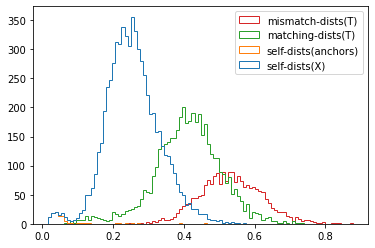

In [52]:
_ = plt.hist([self_dists, anchor_selfdists, dists_matching, dists_mismatch], bins=100, histtype="step", 
             label=["self-dists(X)", "self-dists(anchors)", "matching-dists(T)", "mismatch-dists(T)"])
plt.legend()
#plt.savefig("visuals/few_anchors_projection_self-and-pair-dists.png")

This, obtained with a **100** word projection, is very different from the histogram in `twofold_gwot` (**1000** word projection): 
self-distance is higher (mean: 0.32 vs. 0.14) and pair-distance of matching pairs is higher (mean: 0.46 vs. 0.34) as well.

Both observations taken together indicate that the mapping projects further away from the original vectors, but not as much towards the optimal landing points claimed by the big coupling $\Gamma_T$. Instead, it projects somewhere else – this makes shift measurable.

The little bump at the bottom left of the graph are the self-distance values for the anchors of $P$ (mean: 0.096; median: 0.059). If all anchors were perfectly stable concepts, these distances would be 0, but they aren't, so $P$ shifts them a little bit as well.

In [53]:
""" relate matching pairs with their cosine distance and print them sorted & ranked """

# we're dealing with matching pairs, so we only need one vocabulary
matching_voc = {w:i for i,w in enumerate([k[0] for k in sorted(T, key=T.get, reverse=True) if k[0]==k[1]])}

w_t_d = {w:dists_matching[matching_voc[w]] for w in matching_voc} # dists_matching is sorted by translation score
for i,w in enumerate(sorted(w_t_d, key=w_t_d.get, reverse=True)):
    print(i,"\t",round(w_t_d[w],4),"\t   ",w)

0 	 0.7322 	    medulla
1 	 0.7282 	    horse
2 	 0.72 	    sensation
3 	 0.7149 	    k.
4 	 0.7139 	    ms
5 	 0.7093 	    tendon
6 	 0.7078 	    spectrum
7 	 0.7055 	    32
8 	 0.6927 	    engines
9 	 0.6861 	    wing
10 	 0.6844 	    machinery
11 	 0.6821 	    harbour
12 	 0.6799 	    31
13 	 0.6777 	    momentum
14 	 0.6764 	    incidence
15 	 0.6701 	    remedy
16 	 0.6626 	    relief
17 	 0.6595 	    terror
18 	 0.6593 	    wild
19 	 0.6578 	    diseases
20 	 0.6565 	    progression
21 	 0.6547 	    department
22 	 0.6534 	    manufacture
23 	 0.651 	    chord
24 	 0.6501 	    pharynx
25 	 0.6471 	    actions
26 	 0.6458 	    nebulous
27 	 0.645 	    wear
28 	 0.6449 	    ox
29 	 0.6448 	    tracing
30 	 0.6445 	    red
31 	 0.6424 	    explosion
32 	 0.6424 	    voluntary
33 	 0.6419 	    impulse
34 	 0.6392 	    prey
35 	 0.6389 	    bold
36 	 0.6384 	    glottis
37 	 0.638 	    calculus
38 	 0.6349 	    reflect
39 	 0.6342 	    paralysis
40 	 0.6336 	    oz.
41 	 0.6325 	    t

660 	 0.502 	    frame
661 	 0.502 	    artillery
662 	 0.5019 	    colouring
663 	 0.5019 	    pas
664 	 0.5019 	    written
665 	 0.5019 	    patches
666 	 0.5019 	    origins
667 	 0.5018 	    sp
668 	 0.5017 	    destined
669 	 0.5016 	    expose
670 	 0.5016 	    beauty
671 	 0.5015 	    removal
672 	 0.5015 	    transfer
673 	 0.5015 	    replace
674 	 0.5014 	    multiplying
675 	 0.5013 	    share
676 	 0.5012 	    pain
677 	 0.5012 	    greenwich
678 	 0.5011 	    steam
679 	 0.5007 	    accomplishment
680 	 0.5005 	    lived
681 	 0.5004 	    der
682 	 0.5003 	    business
683 	 0.5002 	    runs
684 	 0.5002 	    clouds
685 	 0.5001 	    horizon
686 	 0.5 	    attending
687 	 0.4999 	    components
688 	 0.4998 	    thoroughly
689 	 0.4998 	    charges
690 	 0.4997 	    refrain
691 	 0.4997 	    uncertainty
692 	 0.4996 	    darker
693 	 0.4996 	    south-east
694 	 0.4993 	    4-1
695 	 0.4992 	    keeping
696 	 0.4991 	    s.
697 	 0.499 	    11
698 	 0.4989 	    conversion

1241 	 0.4615 	    anterior
1242 	 0.4614 	    copiously
1243 	 0.4614 	    barrier
1244 	 0.4613 	    rule
1245 	 0.4613 	    decompositions
1246 	 0.4613 	    fault
1247 	 0.4612 	    negro
1248 	 0.4612 	    electrolytic
1249 	 0.4612 	    investing
1250 	 0.4611 	    234
1251 	 0.4611 	    regards
1252 	 0.4611 	    basis
1253 	 0.461 	    ix
1254 	 0.461 	    cut
1255 	 0.4609 	    joint
1256 	 0.4609 	    exp.
1257 	 0.4608 	    +f
1258 	 0.4607 	    reptile
1259 	 0.4606 	    knew
1260 	 0.4605 	    forces
1261 	 0.4604 	    corresponded
1262 	 0.4604 	    r3
1263 	 0.4604 	    sheet
1264 	 0.4602 	    ir
1265 	 0.4601 	    contrived
1266 	 0.4601 	    standard
1267 	 0.46 	    i3
1268 	 0.46 	    ds
1269 	 0.46 	    consecutive
1270 	 0.46 	    transferred
1271 	 0.4599 	    communicating
1272 	 0.4599 	    parallax
1273 	 0.4599 	    screen
1274 	 0.4599 	    destroyed
1275 	 0.4599 	    denotes
1276 	 0.4599 	    introduction
1277 	 0.4598 	    deposit
1278 	 0.4598 	    perp

1751 	 0.4357 	    torn
1752 	 0.4356 	    movement
1753 	 0.4356 	    perfection
1754 	 0.4354 	    liquids
1755 	 0.4354 	    vernier
1756 	 0.4353 	    dryness
1757 	 0.4353 	    check
1758 	 0.4351 	    graduated
1759 	 0.4351 	    hear
1760 	 0.435 	    inspiration
1761 	 0.435 	    tied
1762 	 0.4349 	    base
1763 	 0.4348 	    mechanical
1764 	 0.4348 	    noted
1765 	 0.4347 	    title
1766 	 0.4347 	    roman
1767 	 0.4346 	    intend
1768 	 0.4346 	    shaped
1769 	 0.4346 	    geology
1770 	 0.4345 	    decussate
1771 	 0.4344 	    convenience
1772 	 0.4343 	    approached
1773 	 0.4343 	    president
1774 	 0.4343 	    died
1775 	 0.4343 	    plant
1776 	 0.4342 	    letter
1777 	 0.4342 	    terminated
1778 	 0.4342 	    fissure
1779 	 0.4342 	    lighted
1780 	 0.4342 	    expectation
1781 	 0.4342 	    permit
1782 	 0.4342 	    muscular
1783 	 0.4341 	    fossil
1784 	 0.4341 	    softened
1785 	 0.434 	    hydrates
1786 	 0.434 	    belonged
1787 	 0.434 	    answers
1

2235 	 0.4128 	    regularity
2236 	 0.4128 	    agitation
2237 	 0.4127 	    condition
2238 	 0.4126 	    representative
2239 	 0.4125 	    moist
2240 	 0.4125 	    decimals
2241 	 0.4124 	    precision
2242 	 0.4123 	    ed.
2243 	 0.4123 	    suspect
2244 	 0.412 	    behind
2245 	 0.412 	    outline
2246 	 0.412 	    settle
2247 	 0.412 	    exclusively
2248 	 0.412 	    unconnected
2249 	 0.4119 	    perihelion
2250 	 0.4119 	    aqueous
2251 	 0.4118 	    229
2252 	 0.4117 	    presumed
2253 	 0.4117 	    f
2254 	 0.4117 	    signs
2255 	 0.4116 	    reagents
2256 	 0.4116 	    thread
2257 	 0.4116 	    philosophy
2258 	 0.4116 	    detect
2259 	 0.4115 	    0-4
2260 	 0.4115 	    transmitted
2261 	 0.4115 	    judge
2262 	 0.4115 	    balls
2263 	 0.4114 	    voltaic
2264 	 0.4113 	    throws
2265 	 0.411 	    physiological
2266 	 0.411 	    allowed
2267 	 0.4108 	    ditto
2268 	 0.4106 	    anticipated
2269 	 0.4105 	    question
2270 	 0.4105 	    confirming
2271 	 0.4105 	  

2667 	 0.3929 	    departments
2668 	 0.3929 	    periods
2669 	 0.3929 	    electro-magnetic
2670 	 0.3928 	    maintains
2671 	 0.3928 	    indeterminate
2672 	 0.3927 	    zinc
2673 	 0.3927 	    honoured
2674 	 0.3926 	    current
2675 	 0.3926 	    peculiar
2676 	 0.3926 	    steadiness
2677 	 0.3924 	    front
2678 	 0.3923 	    minute
2679 	 0.3923 	    superposition
2680 	 0.3923 	    museum
2681 	 0.3923 	    principle
2682 	 0.3922 	    continues
2683 	 0.3922 	    shifted
2684 	 0.3922 	    nous
2685 	 0.3921 	    retarding
2686 	 0.3921 	    devised
2687 	 0.392 	    requisite
2688 	 0.392 	    lately
2689 	 0.392 	    light
2690 	 0.3919 	    ounce
2691 	 0.3919 	    altitudes
2692 	 0.3918 	    proportionate
2693 	 0.3918 	    freely
2694 	 0.3918 	    620
2695 	 0.3918 	    practically
2696 	 0.3918 	    inequalities
2697 	 0.3918 	    227
2698 	 0.3918 	    *
2699 	 0.3916 	    unequal
2700 	 0.3915 	    existed
2701 	 0.3915 	    simplified
2702 	 0.3915 	    arisen
27

3109 	 0.3695 	    midst
3110 	 0.3695 	    nowhere
3111 	 0.3694 	    discoverer
3112 	 0.3694 	    robinson
3113 	 0.3692 	    chief
3114 	 0.3692 	    imperfect
3115 	 0.3691 	    closer
3116 	 0.3691 	    disposal
3117 	 0.369 	    equinoxes
3118 	 0.369 	    believing
3119 	 0.369 	    delicate
3120 	 0.3689 	    entire
3121 	 0.3689 	    thereto
3122 	 0.3688 	    %
3123 	 0.3688 	    fewer
3124 	 0.3688 	    memorandum
3125 	 0.3687 	    touched
3126 	 0.3687 	    life
3127 	 0.3685 	    reserved
3128 	 0.3685 	    recorded
3129 	 0.3684 	    admit
3130 	 0.3684 	    doubt
3131 	 0.3682 	    cited
3132 	 0.3682 	    ibid.
3133 	 0.3682 	    specific
3134 	 0.3681 	    placing
3135 	 0.3681 	    force
3136 	 0.3681 	    -7
3137 	 0.3681 	    xl
3138 	 0.3681 	    2
3139 	 0.368 	    reason
3140 	 0.368 	    fortunate
3141 	 0.368 	    gently
3142 	 0.3679 	    measurements
3143 	 0.3679 	    wanting
3144 	 0.3679 	    vitriol
3145 	 0.3679 	    boiling
3146 	 0.3679 	    resemble

3563 	 0.3419 	    diminished
3564 	 0.3419 	    consist
3565 	 0.3419 	    incompatible
3566 	 0.3418 	    alluded
3567 	 0.3418 	    295
3568 	 0.3417 	    deemed
3569 	 0.3417 	    certainty
3570 	 0.3416 	    propelled
3571 	 0.3415 	    fortunately
3572 	 0.3414 	    diminution
3573 	 0.3414 	    preserve
3574 	 0.3414 	    aware
3575 	 0.3414 	    dated
3576 	 0.3412 	    +d
3577 	 0.3412 	    nitre
3578 	 0.3412 	    decided
3579 	 0.3411 	    carlisle
3580 	 0.341 	    suffice
3581 	 0.341 	    stations
3582 	 0.341 	    bear
3583 	 0.3409 	    sulphuric
3584 	 0.3409 	    presents
3585 	 0.3408 	    457
3586 	 0.3407 	    alone
3587 	 0.3406 	    revolving
3588 	 0.3406 	    examinations
3589 	 0.3405 	    experimenter
3590 	 0.3405 	    accordingly
3591 	 0.3405 	    partly
3592 	 0.3404 	    hour
3593 	 0.3404 	    dissolved
3594 	 0.3404 	    scrutators
3595 	 0.3403 	    sectional
3596 	 0.3401 	    confident
3597 	 0.3401 	    merely
3598 	 0.34 	    promoting
3599 	 0.34

4017 	 0.3019 	    series
4018 	 0.3014 	    208
4019 	 0.3012 	    herschel
4020 	 0.301 	    according
4021 	 0.3009 	    vary
4022 	 0.3009 	    y3
4023 	 0.3007 	    arising
4024 	 0.3007 	    giving
4025 	 0.3005 	    vol.
4026 	 0.3004 	    exercises
4027 	 0.3004 	    fact
4028 	 0.3002 	    successive
4029 	 0.3 	    take
4030 	 0.2998 	    none
4031 	 0.2996 	    appear
4032 	 0.2991 	    salt
4033 	 0.299 	    mathematics
4034 	 0.2989 	    along
4035 	 0.2989 	    formation
4036 	 0.2987 	    come
4037 	 0.2986 	    value
4038 	 0.2986 	    mentions
4039 	 0.2984 	    intelligent
4040 	 0.2983 	    fail
4041 	 0.2981 	    higher
4042 	 0.2977 	    mathematical
4043 	 0.2977 	    difference
4044 	 0.2976 	    extensive
4045 	 0.2976 	    round
4046 	 0.2973 	    carefully
4047 	 0.2972 	    underneath
4048 	 0.2968 	    think
4049 	 0.2968 	    investigation
4050 	 0.2966 	    considering
4051 	 0.2964 	    putting
4052 	 0.2961 	    rotate
4053 	 0.296 	    show
4054 	 0.295